In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.optim import AdamW
import numpy as np
import copy
from torch.distributions.categorical import Categorical
from collections import deque
import gymnasium as gym
from gym.spaces import Discrete, Box
from itertools import count
from torch.utils.data import IterableDataset
from torch.utils.data import DataLoader
from gym.wrappers import NormalizeReward
import matplotlib.pyplot as plt

In [96]:
env_name = 'LunarLanderContinuous-v2'

In [97]:
# ActorCritic Network
class ActorCriticNet(nn.Module):
    def __init__(self, input_size, hidden_units, output_size):
        super(ActorCriticNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, int(hidden_units/2)),
            nn.ReLU()
        )
        self.actor_head = nn.Linear(int(hidden_units/2),  output_size)
        self.value_head = nn.Linear(int(hidden_units/2), 1)

    def forward(self, x):
        x = self.model(x)
        loc = torch.tanh(self.actor_head(x)) * 2
        value = self.value_head(x)
        return loc, value

    def __call__(self, x):
        out = self.forward(x)
        return out

In [98]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

In [99]:
env = gym.vector.make(env_name, num_envs=8)
#env = NormalizeReward(env)
obs_dim = env.single_observation_space.shape[0]
n_acts = env.single_action_space.shape[0]


In [100]:
# Actor-Critic networks
hidden_sizes = 128
ac_net = ActorCriticNet(obs_dim, hidden_sizes, n_acts)
ac_net = ac_net.apply(initialize_weights)

In [101]:
# optimizer
optimizer = AdamW(ac_net.parameters(), lr=0.001)

In [102]:
T = lambda x: torch.as_tensor(x, dtype=torch.float32)
Ti = lambda x: torch.as_tensor(x, dtype=torch.int64)

In [103]:
@torch.no_grad()
def run_test(trajectories, policy):
    env2 = gym.make(env_name)
    scores = []
    for trajectory in range(trajectories):
        trajectory_return = 0
        obs, info = env2.reset()
        terminated, truncated = False, False
        while not terminated and not truncated:
            with torch.no_grad():
                action_loc, _ = policy(T(obs).unsqueeze(0))
            next_obs, reward, terminated, truncated, _ = env2.step(action_loc.tolist()[0])
            obs = next_obs
            trajectory_return += reward
        scores.append(trajectory_return)
    del env2
    return np.mean(scores)

In [104]:
results = deque(maxlen=50)
gamma=.99
nsteps=128
final_result=[]
obs, info = env.reset()
for epoc in count():
    for steps in range(nsteps):
        action_loc, state_value = ac_net(T(obs))

        dist = Normal(loc=action_loc, scale=1.0)
        action = dist.sample()
        next_obs, reward, terminated, truncated, _ = env.step(action.numpy())
        #print(action.numpy())
        _, next_state_value = ac_net(T(next_obs))
        next_state_value[terminated] = 0.0
        target = T(reward).unsqueeze(1) + gamma * next_state_value

        optimizer.zero_grad()
        value_loss =  F.smooth_l1_loss(target, state_value)        
        advantage = (target - state_value).detach()
        advantage = (advantage - torch.mean(advantage)) / (torch.std(advantage) + 1e-6)
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()
        policy_loss = -(log_prob * advantage).mean() + 0.001*entropy.mean()
        
        (policy_loss + 0.5*value_loss).backward()
        optimizer.step()

        obs = next_obs
        
    var = run_test(1, ac_net)
    results.append(var)
    score  = np.mean(results)
    final_result.append(var)
    if epoc>1 and epoc % 50 == 0:
        print(f'Episode: {epoc} \t Average Return: {score}')
    if score >= 195:
        print(f'Solved! Episode: {epoc} \t Average Return: {score}')
        break

Episode: 50 	 Average Return: -175.28508043990135
Episode: 100 	 Average Return: -8.385887109938114
Episode: 150 	 Average Return: 107.02512634110352
Episode: 200 	 Average Return: 110.38551485881813
Episode: 250 	 Average Return: 167.17181654083367
Episode: 300 	 Average Return: 151.07453350619588
Episode: 350 	 Average Return: 137.37536880540108
Episode: 400 	 Average Return: 132.32595239745172
Episode: 450 	 Average Return: 123.22569159134662
Episode: 500 	 Average Return: 143.54241777248524
Episode: 550 	 Average Return: 109.29331128270535
Episode: 600 	 Average Return: 146.48536706558798
Episode: 650 	 Average Return: 163.7533364235324
Episode: 700 	 Average Return: 160.94399883538054
Episode: 750 	 Average Return: 146.62646945443817
Episode: 800 	 Average Return: 132.92230855893249
Episode: 850 	 Average Return: 151.38712725766712
Episode: 900 	 Average Return: 95.6313069745659
Episode: 950 	 Average Return: 115.83560194667399
Episode: 1000 	 Average Return: 162.33212669419024
Ep

KeyboardInterrupt: 

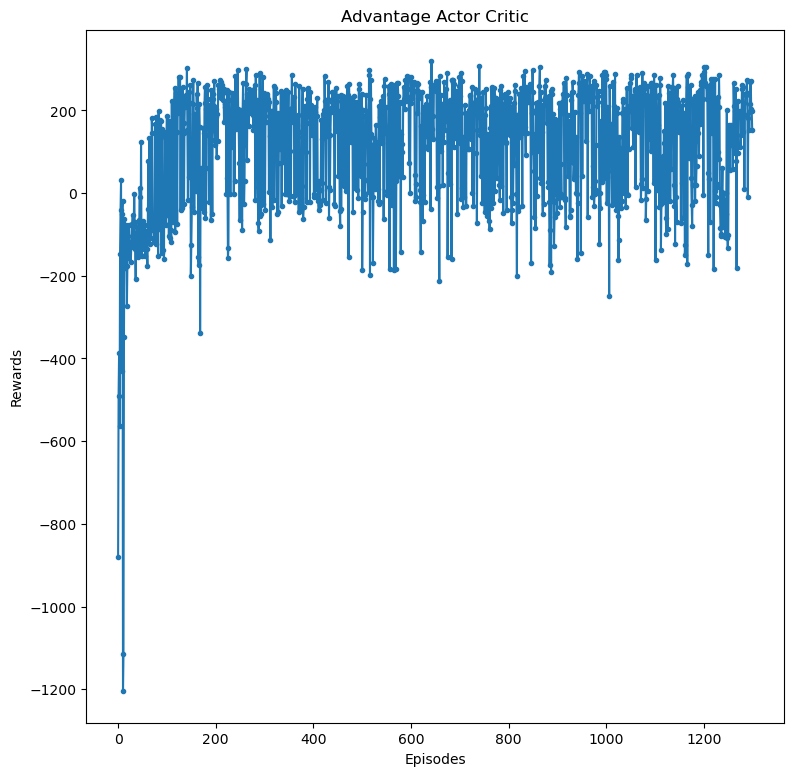

In [105]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(final_result)), final_result, marker='.')
plt.title('Advantage Actor Critic')
plt.ylabel('Rewards')
plt.xlabel('Episodes')
plt.show()